<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Exercise_Regression_metrics_insurance_charge_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Exercise: Metrics for Regression and Hyperparameter tuning**
---

## **Business Understanding**

An insurance company asks you to create a model to predict how much a customer will claim based on their characteristics.

**Use the 'insurance' dataset**

Find the best model and hyperparameters to predict insurance costs for each individual based on their characteristics.
1. Perform a brief EDA to explore the dataset first.
2. Preprocess the features if needed.
3. Perform modeling using lasso regression, KNN regressor, and decision tree regressor.
  >Candidate algorithms:
  > * lasso = Lasso(alpha=1)
  > * knn = KNeighborsRegressor(n_neighbors=5)
  > * tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)
4. Select the best model based on the cross-validation results of the three models above.
5. Perform hyperparameter tuning on the selected model.
6. Make predictions on the test set of the selected model (before hyperparameter tuning).
7. Make predictions on the test set of the model with hyperparameter tuning.
8. Compare the model performance results before and after tuning.
9. Create a Residual Plot

**Features Description**

- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

**Initial setup**

In [1]:
# Install additional libraries
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Splitting
from sklearn.model_selection import train_test_split

# Data preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, MinMaxScaler

# ML Algorithms
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Metrics, model evaluation, hyperparameter tuning
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# ggplot style
plt.style.use('ggplot')

# warnings
import warnings
warnings.filterwarnings('ignore')

## **Data understanding**

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# check missing values
df.isna().sum().to_frame('missing values')

,missing values
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [6]:
# Descriptive statistics
display(df.describe(include='object'), df.describe())

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## **Data Cleaning and Exploratory Data Analysis**

In [7]:
# Categorical features
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['sex', 'smoker', 'region']

In [8]:
# Numerical features
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['age', 'bmi', 'children']

In [9]:
# Unique values in categorical features
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in sex:  2
Unique values:  ['female' 'male']

Total unique values in smoker:  2
Unique values:  ['yes' 'no']

Total unique values in region:  4
Unique values:  ['southwest' 'southeast' 'northwest' 'northeast']



In [10]:
# Feature Correlation to target
df.select_dtypes(['float', 'int']).corr()['charges']

,charges
age,0.299008
bmi,0.198341
children,0.067998
charges,1.000000


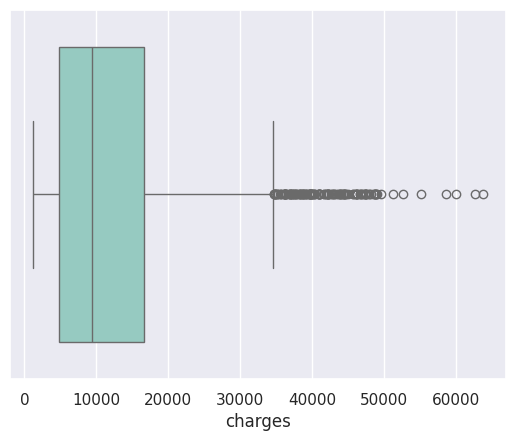

In [11]:
# Boxplot of charges
sns.set(palette='Set3')
sns.boxplot(x='charges', data=df);

### Outliers

We might want to consider dropping outliers.

In [12]:
df.shape

(1338, 7)

In [13]:
df = df[df['charges']<50000]
df.shape

(1331, 7)

### **Plot of categorical features**

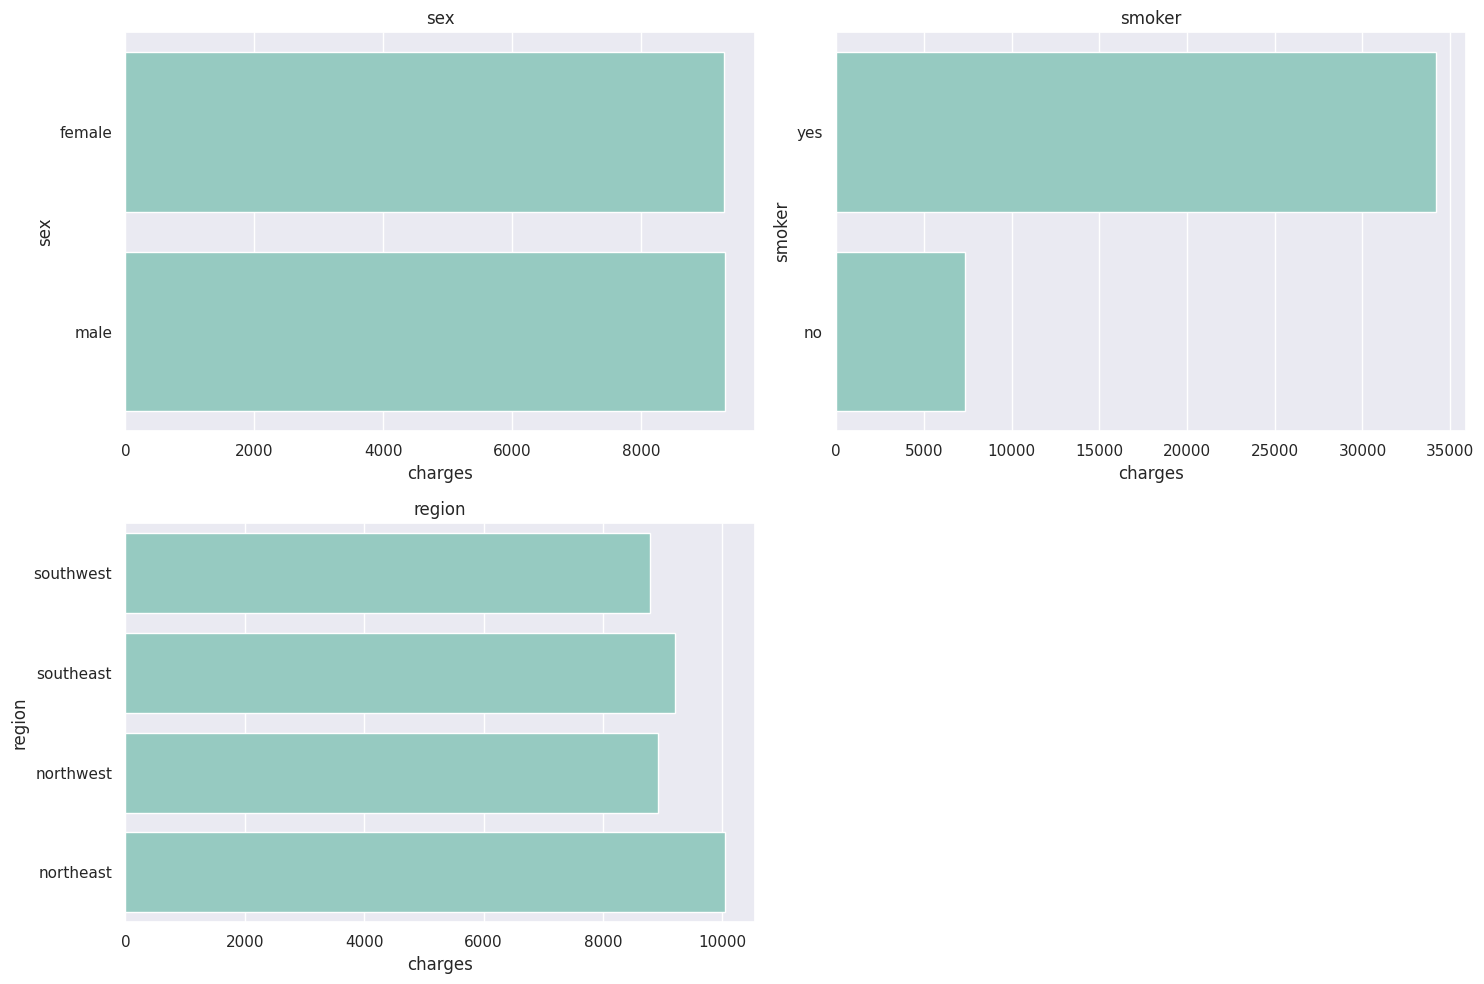

In [14]:
plt.figure(figsize=(15, 10), facecolor='white')
plotnumber = 1

for feature in cat_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.barplot(x = 'charges', y = feature, data = df, ci=0, estimator=np.median)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

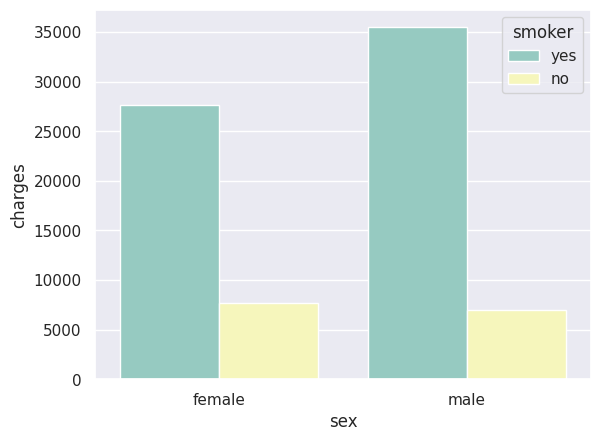

In [15]:
# Sex and Smoker Vs Charges
sns.barplot(data=df, x='sex', y='charges', hue='smoker', estimator=np.median, ci=0);

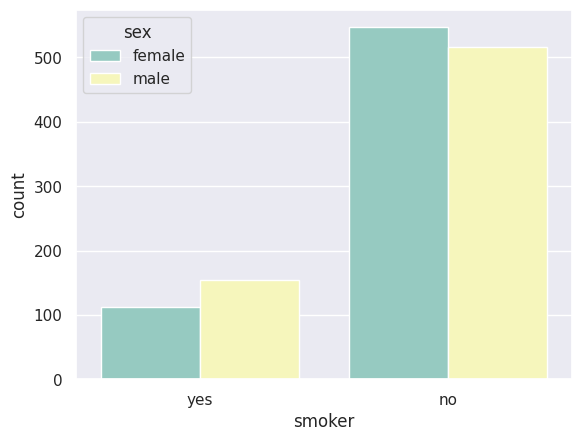

In [16]:
# Total number of smoker vs not smoker (male and female)
sns.countplot(data=df, x='smoker', hue='sex');

### **Plot of numerical features**

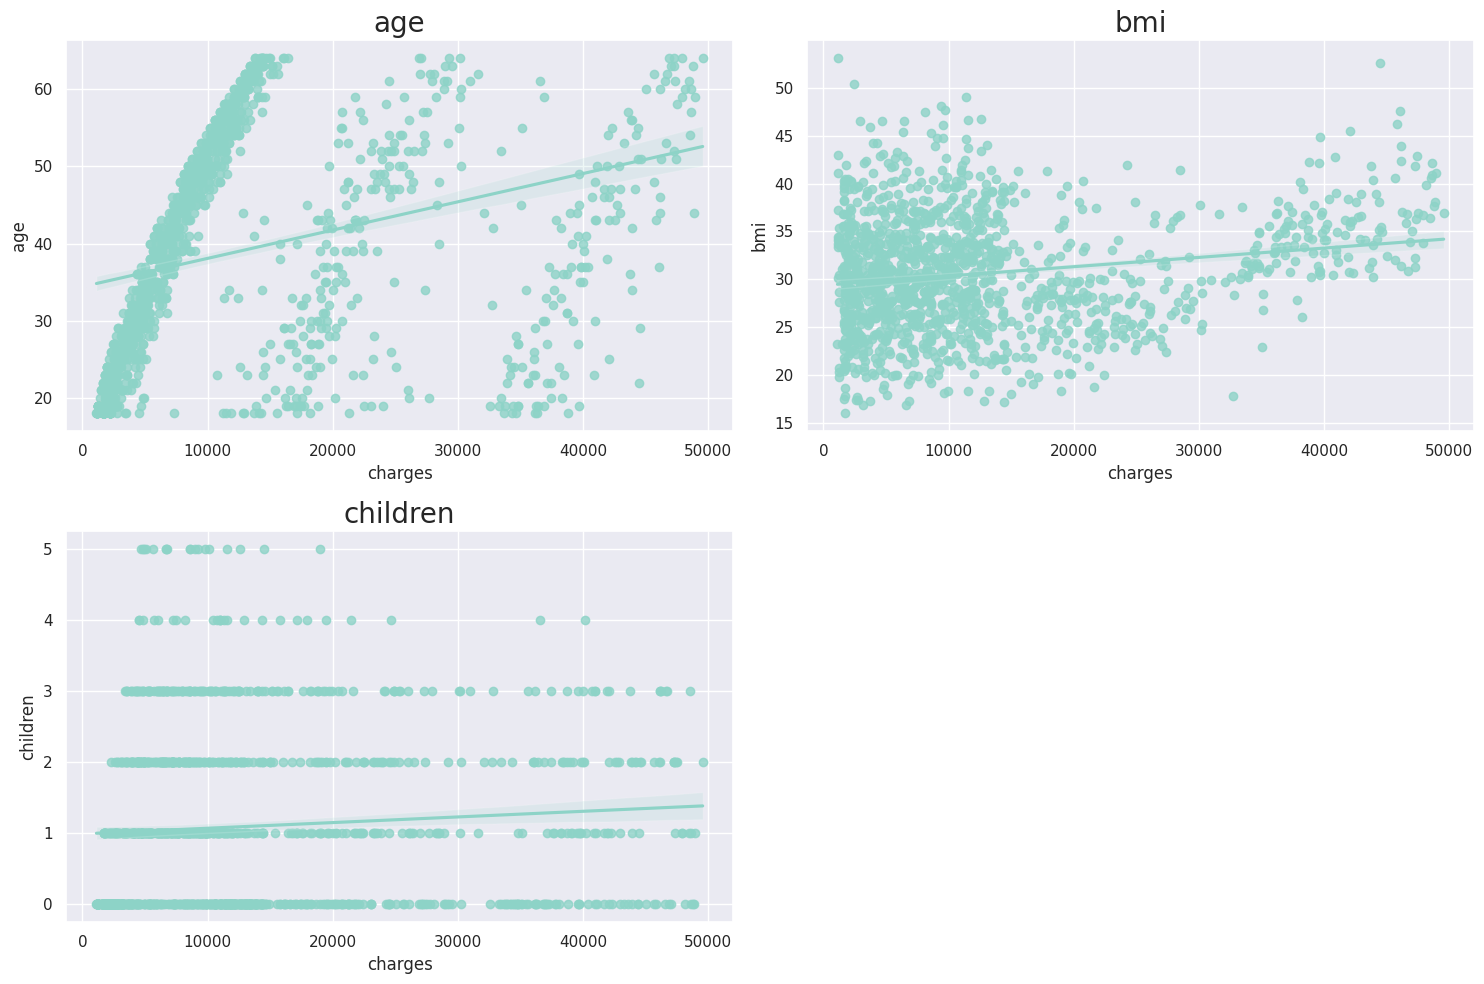

In [17]:
plt.figure(figsize=(15, 10))
plotnumber = 1

for feature in num_features:

    ax = plt.subplot(2, 2, plotnumber)
    sns.regplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature, fontsize=20)
    plt.tight_layout();

    plotnumber += 1

In [18]:
df.select_dtypes(['float', 'int']).corr(method='spearman')

,age,bmi,children,charges
age,1.000000,0.107189,0.058525,0.536881
bmi,0.107189,1.000000,0.016991,0.112180
children,0.058525,0.016991,1.000000,0.137781
charges,0.536881,0.112180,0.137781,1.000000


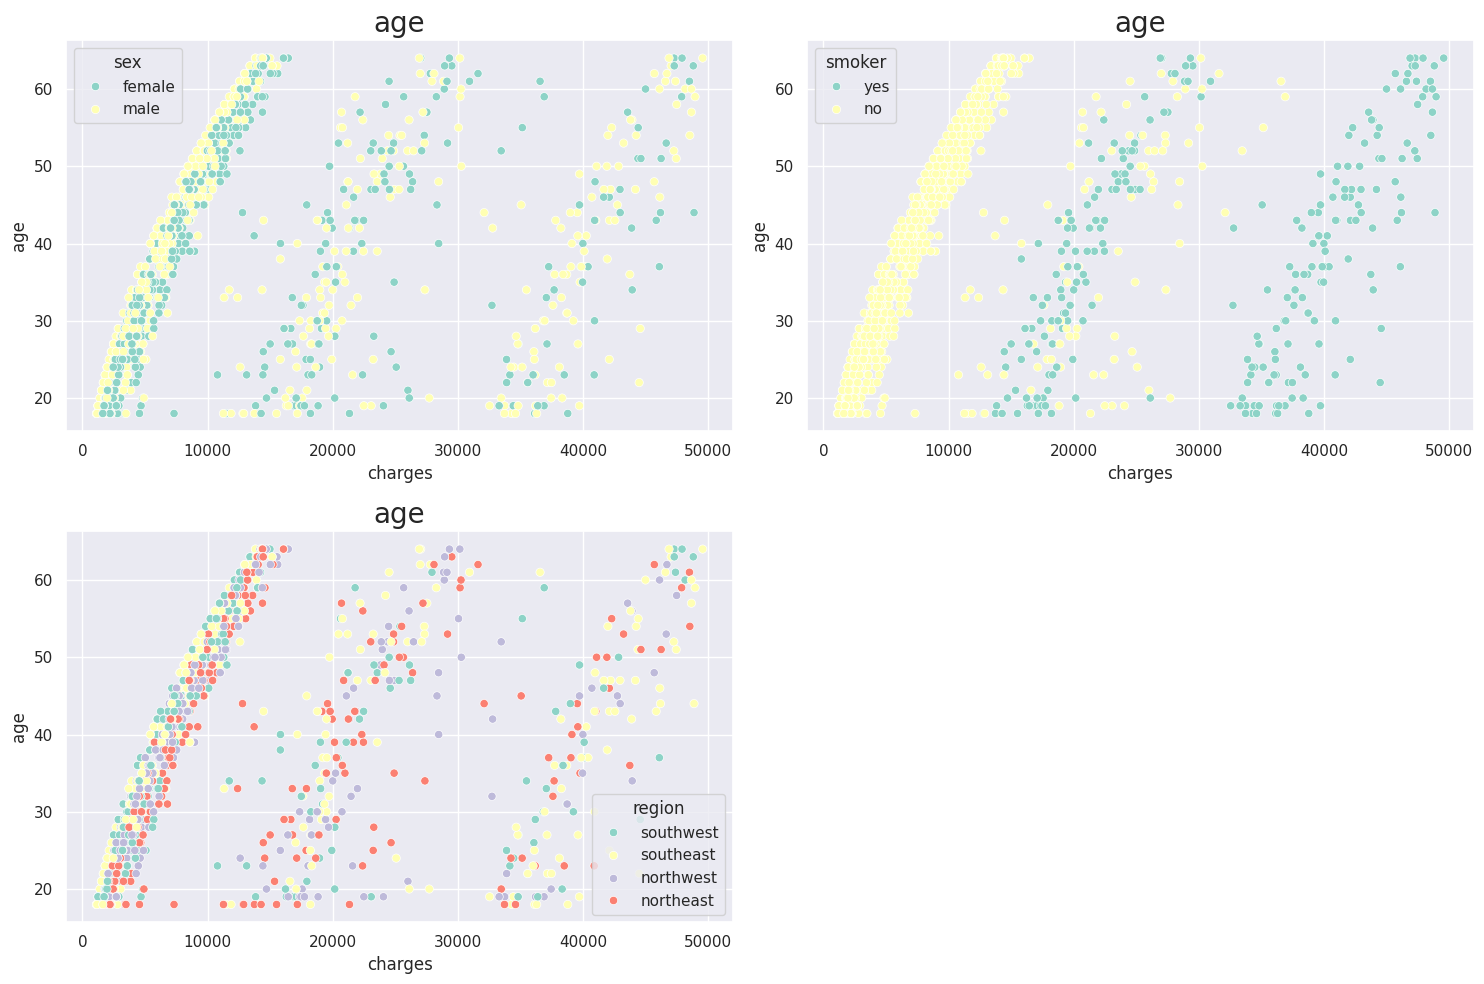

In [19]:
plt.figure(figsize=(15, 10))
plotnumber = 1

for feature in cat_features:

    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = 'age', hue=feature, data = df)
    plt.xlabel('charges')
    plt.title('age', fontsize=20)
    plt.tight_layout();

    plotnumber += 1

In [20]:
# Correlation smoker = 'no' to charges
df[df['smoker']=='no'].select_dtypes(['float', 'int']).corr(method='spearman')

,age,bmi,children,charges
age,1.000000,0.119242,0.042534,0.820661
bmi,0.119242,1.000000,0.016043,0.105132
children,0.042534,0.016043,1.000000,0.181491
charges,0.820661,0.105132,0.181491,1.000000


In [21]:
# Correlation smoker = 'yes' to charges
df[df['smoker']=='yes'].select_dtypes(['float', 'int']).corr(method='spearman')

,age,bmi,children,charges
age,1.000000,0.052650,0.121048,0.457088
bmi,0.052650,1.000000,0.016962,0.837823
children,0.121048,0.016962,1.000000,0.107982
charges,0.457088,0.837823,0.107982,1.000000


In [22]:
df.shape

(1331, 7)

### **Handling duplicates**

In [23]:
# dropping duplicates
df = df.drop_duplicates()
df.shape

(1330, 7)

## **Data Preparation**

### **Define features and target**

In [24]:
# Define X and y
X = df.drop(columns='charges')
y = df['charges']

### **Data Splitting**

In [25]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0
)

### **Feature engineering**

In [26]:
# encoder
transformer = ColumnTransformer([
    ('scaler', RobustScaler(), ['age', 'bmi', 'children']), # Untuk numerikal
    ('onehot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']) # untuk kategorikal
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['sex', 'smoker', 'region'])])

## **Model Building**
- Here, we'll try modeling with a pipeline (feature transformation and scaling are performed in one stage).
- It's recommended to use a Pipeline to avoid information leakage.


### **Cross Validation**

- Correct example: in Split 1, Fold 1 should not be included in the fit_transform; it should only be transformed.
- By using a Pipeline, in Split 1, Fold 1 is automatically not included in the fit_transform; it is only transformed.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Drawing" style="width: 250px;"/>


In [27]:
# various metrics
import sklearn
from sklearn import metrics
# metrics.SCORERS.keys()
# sklearn.metrics.get_scorer_names() # Uncomment this to know metrics

In [28]:
# Define 3 candidate models
lasso = Lasso(alpha=1)
knn = KNeighborsRegressor(n_neighbors=5)
tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)

In [29]:
# define lasso
i = lasso

pipe_model =Pipeline([
                    ('preprocess', transformer),
                    ('model', i)
                ])

scorer = [
    'neg_root_mean_squared_error',        # RMSE
    'neg_mean_absolute_error',            # MAE
    'neg_mean_absolute_percentage_error'  # MAPE
    ]

model_cv = cross_validate(
    estimator = pipe_model,
    X = X_train,
    y = y_train,
    cv = 5,
    scoring = scorer
    )

# model_cv
# print(model_cv['test_neg_root_mean_squared_error'])
print('RMSE Score:')
print(model_cv['test_neg_root_mean_squared_error'].mean())
print(model_cv['test_neg_root_mean_squared_error'].std())
print('MAE Score:')
print(model_cv['test_neg_mean_absolute_error'].mean())
print(model_cv['test_neg_mean_absolute_error'].std())
print('MAPE Score:')
print(model_cv['test_neg_mean_absolute_percentage_error'].mean())
print(model_cv['test_neg_mean_absolute_percentage_error'].std())


RMSE Score:
-5861.517579525238
244.30482759970758
MAE Score:
-4127.756831439089
151.75586607001682
MAPE Score:
-0.42657907080774154
0.04887033762936508


In [30]:
# Algorithm Model Selection
models = [lasso, knn, tree]

list_mean_rmse = []
list_std_rmse = []

list_mean_mae = []
list_std_mae = []

list_mean_mape = []
list_std_mape = []

# Find the best model based on the smallest MAE
for i in models:

# The pipeline contains 3 stages, to be filled in the estimator in cross val
  pipe_model = Pipeline([
                        ('preprocess', transformer),
                        ('model', i)
                        ])

# cross val
  cv_score = cross_validate(
  estimator = pipe_model,
  X = X_train, # Use the initial X_train (because transform and scaling are done in the pipeline)
  y = y_train,
  cv = 5,
  scoring = scorer
  )

  list_mean_rmse.append(cv_score['test_neg_root_mean_squared_error'].mean())
  list_std_rmse.append(cv_score['test_neg_root_mean_squared_error'].std())

  list_mean_mae.append(cv_score['test_neg_mean_absolute_error'].mean())
  list_std_mae.append(cv_score['test_neg_mean_absolute_error'].std())

  list_mean_mape.append(cv_score['test_neg_mean_absolute_percentage_error'].mean())
  list_std_mape.append(cv_score['test_neg_mean_absolute_percentage_error'].std())

In [31]:
# Results
df_cv = pd.DataFrame()
df_cv['algo'] = models

df_cv['mean_RMSE'] = list_mean_rmse
df_cv['std_RMSE'] = list_std_rmse

df_cv['mean_MAE'] = list_mean_mae
df_cv['std_MAE'] = list_std_mae

df_cv['mean_MAPE'] = list_mean_mape
df_cv['std_MAPE'] = list_std_mape


df_cv

,algo,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_MAPE,std_MAPE
0,Lasso(alpha=1),-5861.517580,244.304828,-4127.756831,151.755866,-0.426579,0.048870
1,KNeighborsRegressor(),-6039.799313,295.846878,-3686.577806,192.380574,-0.390974,0.034528
2,DecisionTreeRegressor(criterion='absolute_erro...,-4472.127636,611.765557,-1980.091239,296.348919,-0.163461,0.030396


### **Interpretation**

- Of the three models tested, the decision tree regressor model produced the smallest error (MAE), with a significant difference.
- The decision tree regressor was the least stable.
- Going forward, only the decision tree regressor model will be tested on the test set and tuned.

## **Hyperparameter Tuning with GridSearch**



Find the best hyperparameters for a decision tree

In [32]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['sex', 'smoker', 'region'])])

In [33]:
# hyperparameter for gridsearch
hyperparam_space = {
    'model__criterion':['absolute_error','squared_error'],                    # benchmark: absolute_error
    'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],                        # benchmark: 1
    'model__max_depth':[5, 6, 7, 8, 9, 10],                                   # benchmark: 5
    'preprocess__scaler':[StandardScaler(), MinMaxScaler(), RobustScaler()]
}

In [34]:
# benchmark model
tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)

# model in the pipeline
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

# Grid search (search for best hyperparameters)
grid_search = GridSearchCV(
    estimator = tree_pipeline,           # model to tune
    param_grid = hyperparam_space,       # hyperparam space
    cv = 5,
    scoring= scorer,
    refit = 'neg_mean_absolute_error', # metric
    n_jobs= -1
)

In [35]:
# fitting grid_search on the train set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model',
                                        DecisionTreeRegressor(criterion='absolute_error',
                                                              max_depth=5,
                                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['absolute_error',
                                              'squared_error'],
                         'model__max_depth': [5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],
                         'preprocess__scaler': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]},
             refit='neg_mean_absolute_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

### **Model Performance in training Set**

In [36]:
# best score (grid_search)
print(grid_search.best_score_)

# hyperparameters for the best score (grid_search)
print(grid_search.best_params_)

-1771.8889726435468
{'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 5, 'preprocess__scaler': StandardScaler()}


In [37]:
df_grid = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_neg_mean_absolute_error')
df_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,param_preprocess__scaler,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
40,0.080758,0.016782,0.019324,0.004707,absolute_error,7,5,MinMaxScaler(),"{'model__criterion': 'absolute_error', 'model_...",-3379.174256,...,235.530826,1,-0.106599,-0.127095,-0.123676,-0.123051,-0.135098,-0.123104,0.009301,1
41,0.082701,0.021196,0.021401,0.005369,absolute_error,7,5,RobustScaler(),"{'model__criterion': 'absolute_error', 'model_...",-3379.174256,...,235.530826,1,-0.106599,-0.127095,-0.123676,-0.123051,-0.135098,-0.123104,0.009301,1
39,0.079190,0.022876,0.021632,0.008201,absolute_error,7,5,StandardScaler(),"{'model__criterion': 'absolute_error', 'model_...",-3379.174256,...,235.530826,1,-0.106599,-0.127095,-0.123676,-0.123051,-0.135098,-0.123104,0.009301,1
93,0.055854,0.014396,0.012480,0.003773,absolute_error,10,5,StandardScaler(),"{'model__criterion': 'absolute_error', 'model_...",-3360.772698,...,267.635947,4,-0.092274,-0.156692,-0.153495,-0.121456,-0.127415,-0.130266,0.023524,16
94,0.048581,0.002520,0.012748,0.002306,absolute_error,10,5,MinMaxScaler(),"{'model__criterion': 'absolute_error', 'model_...",-3360.772698,...,267.635947,4,-0.092274,-0.156692,-0.153495,-0.121456,-0.127415,-0.130266,0.023524,16


In [38]:
print(df_cv.loc[2, 'mean_MAE'], 'MAE before tuning')
print(df_grid.loc[39, 'mean_test_neg_mean_absolute_error'], 'MAE after tuning')

-1980.0912394271859 MAE before tuning
-1771.8889726435468 MAE after tuning


**MAE on the train set:**
- before hyperparameter tuning: 1980 (mean MAE on the cross-validation benchmark model)
- after hyperparameter tuning: 1771 (mean MAE on the grid search)

Hyperparameter tuning successfully improved model performance on the train set

### **Model Performance in Testing Set**
Now let's predict the model tree on the test set and see the performance results.

**Benchmark Model (Before Hyperparameter Tuning)**

In [39]:
# model benchmark
tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)

# model benchmark
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

# fitting
tree_pipeline.fit(X_train, y_train)

# predict
y_pred = tree_pipeline.predict(X_test)

In [40]:
# Metric evaluation
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('MAPE:', mape)
print('RMSE:', rmse)
print('MAE:', mae)

MAPE: 0.15092630948074573
RMSE: 4627.251089223093
MAE: 1910.6784024962406


**Best Model (After Hyperparameter Tuning)**

In [41]:
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                                       min_samples_leaf=5, random_state=0))])

In [42]:
# Select the best hyperparameter with manual definition

# preprocess (best)
transformer = ColumnTransformer([
  ('scaler', StandardScaler(), ['age', 'bmi', 'children']),
  ('onehot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
], remainder='passthrough')

# model (best)
tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=5, max_depth=7, random_state=0)

# pipelines
best_model = Pipeline([
  ('preprocess', transformer),
  ('model', tree)
])

best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                                       min_samples_leaf=5, random_state=0))])

In [43]:
# # Model after hyperparameter tuning
best_model = grid_search.best_estimator_

# fitting
best_model.fit(X_train, y_train)

# predict
y_pred_best = best_model.predict(X_test)

In [44]:
# Metric evaluation
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse)
mae_best = mean_absolute_error(y_test, y_pred_best)

print('MAPE:', mape_best)
print('RMSE:', rmse_best)
print('MAE:', mae_best)

MAPE: 0.12815245659289967
RMSE: 4627.251089223093
MAE: 1825.464804451128


**Comparison of before and after tuning model - Gridsearch**
Comparison of performance on the test set

In [45]:
pd.DataFrame({
    'Metrics->':['Before tuning', 'After tuning'],
    'MAPE':[mape,mape_best],
    'RMSE':[rmse,rmse_best],
    'MAE':[mae, mae_best]
})

,Metrics->,MAPE,RMSE,MAE
0,Before tuning,0.150926,4627.251089,1910.678402
1,After tuning,0.128152,4627.251089,1825.464804


In [46]:
grid_search.best_params_

{'model__criterion': 'absolute_error',
 'model__max_depth': 7,
 'model__min_samples_leaf': 5,
 'preprocess__scaler': StandardScaler()}

### **Interpretation - Grid search**

- The model selected for modeling this dataset is a Decision Tree.
- Hyperparameter tuning successfully improved the performance of the Decision Tree model based on MAE.
- MAE before tuning: 1910
- MAE after tuning: 1825 (grid search).
- The best hyperparameters based on GridSearch are **{'model__criterion': 'absolute_error', 'model__max_depth': 7,'model__min_samples_leaf': 5}**
- After tuning, MAPE and MAE improved, while RMSE still constant. This is likely due to the model before tuning.


Solutions when hyperparameter tuning fails to improve model performance:
- Reset the values ​​entered in the hyperparameters.
- Change the ML algorithm.
- Feature Engineering.
- Add hyperparameters.

### **Residual Plot**

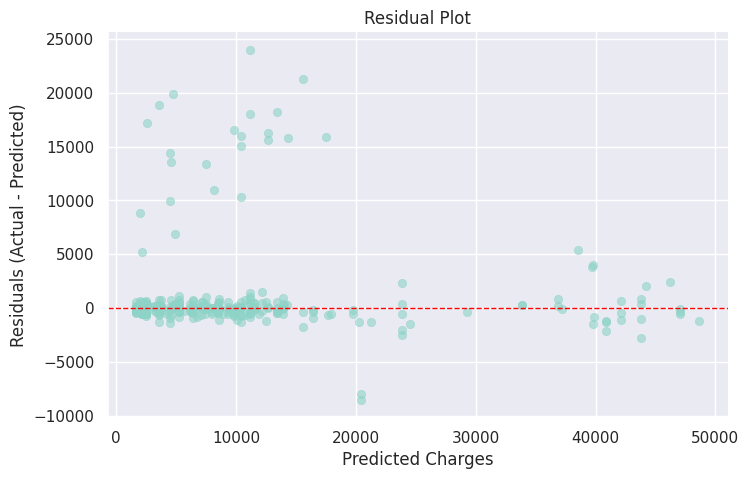

In [73]:
# Calculate residuals # Grid search
residual = y_test - y_pred_best

# Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_best, y=residual, alpha=0.6, edgecolor=None)

# Add reference lines
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals (Actual - Predicted)")
sns.despine()
plt.show()


### **Actual vs Prediction Scatterplot**

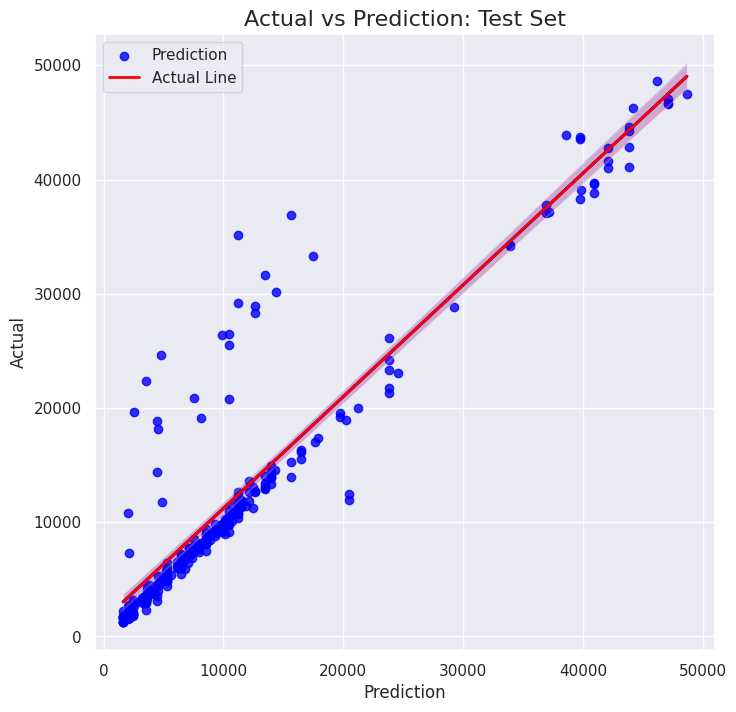

In [75]:
plt.figure(figsize=(8,8))

sns.regplot(y=y_test, x=y_pred_best, color='blue', label='Prediction')
sns.regplot(y=y_test, x=y_pred_best, line_kws = {'linewidth': 2}, scatter=False, color='red', label='Actual Line')

plt.title('Actual vs Prediction: Test Set', fontsize=16)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.legend()
plt.show()

### **Feature Importance**

In [49]:
from sklearn.tree import plot_tree

In [50]:
tree_pipeline['model']

DecisionTreeRegressor(criterion='absolute_error', max_depth=5, random_state=0)

In [51]:
transformer.fit(X_train)
transformer.get_feature_names_out()

array(['scaler__age', 'scaler__bmi', 'scaler__children',
       'onehot__sex_male', 'onehot__smoker_yes',
       'onehot__region_northwest', 'onehot__region_southeast',
       'onehot__region_southwest'], dtype=object)

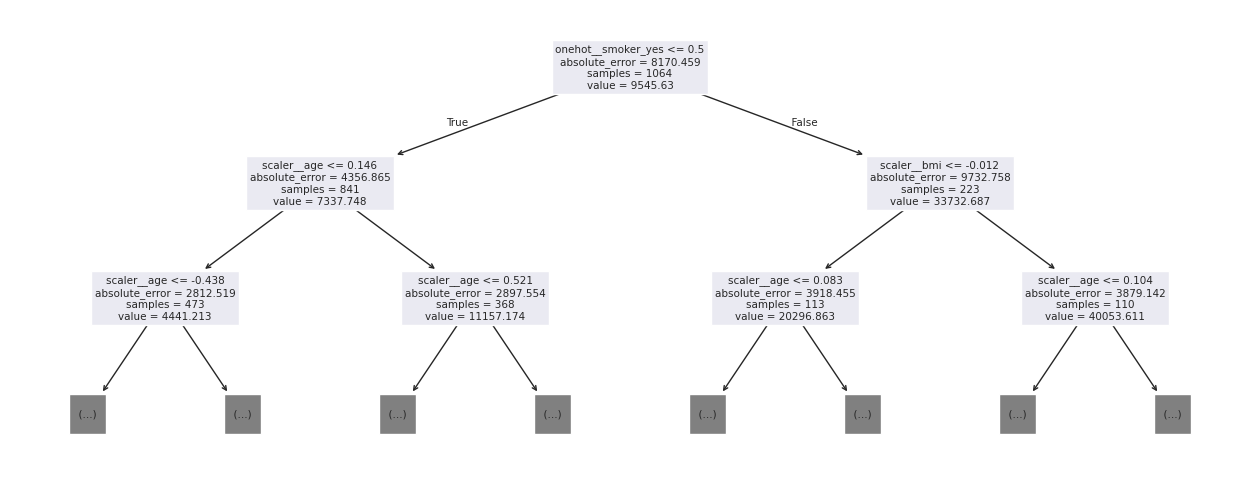

In [52]:
# Plot tree # Model interpretation
plt.figure(figsize=(16,6))
plot_tree(decision_tree=tree_pipeline['model'], max_depth=2, feature_names=transformer.get_feature_names_out());

In [53]:
best_model['model'].feature_importances_

array([3.59856238e-01, 2.03141504e-01, 2.69847701e-02, 3.03592562e-03,
       4.04578069e-01, 2.85158385e-04, 1.60482507e-03, 5.13509836e-04])

In [63]:
df_feature_importances_gridsearch = pd.DataFrame({
    'feature': transformer.get_feature_names_out(),
    'importance': best_model['model'].feature_importances_
}).sort_values('importance', ascending=False)

df_feature_importances_gridsearch

,feature,importance
4,onehot__smoker_yes,0.404578
0,scaler__age,0.359856
1,scaler__bmi,0.203142
2,scaler__children,0.026985
3,onehot__sex_male,0.003036
6,onehot__region_southeast,0.001605
7,onehot__region_southwest,0.000514
5,onehot__region_northwest,0.000285


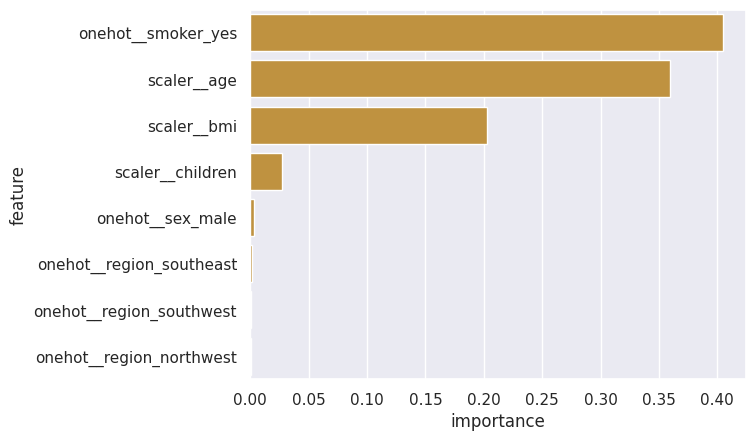

In [64]:
sns.barplot(data=df_feature_importances_gridsearch, x='importance', y='feature', color='orange', saturation=0.5)
plt.show()

**Try to predict to a person**

In [55]:
prospect_A = X_test.head(1)
prospect_A

,age,sex,bmi,children,smoker,region
1295,20,male,22.0,1,no,southwest


In [56]:
best_model.predict(prospect_A)

array([2458.61105])

## **Hyperparameter Tuning with RandomizedSearch**

In [57]:
# hyperparameter for param_distributions
hyperparam_space = {
    'algo__criterion':['absolute_error', 'squared_error'],
    'algo__max_depth': range(1,101),
    'algo__min_samples_leaf': range(1,101)
}

# create a pipeline to include in the RandomizedSearchCV estimator
pipe_model = Pipeline([
    ('transformer', transformer),
    ('algo', tree)
])

random_search = RandomizedSearchCV(
    estimator= pipe_model,                      # model
    param_distributions= hyperparam_space,      # hyperparameters for tunning
    cv= 5,                                      # fold number for cross validation
    scoring= 'neg_mean_absolute_error',         # metrics
    n_jobs= -1,                                 # use all processor
    n_iter= 100,                                # fitting combination
    random_state=0
)

# fitting RandomizedSearchCV to the training set
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('algo',
                                              DecisionTreeRegressor(criterion='absolute_error',
                                                                    max_depth=7,
                                                                    min_samples_leaf=5,
                                                                    random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'algo__criterion': ['absolute_error',
                                                            'squared_error'],
                                        'algo__max_depth': range(1, 101),
                                        'algo__min_samples_leaf': range(1, 101)},
                   random_state=0, scoring='neg_mean_absolute_error')

### **Model Performance in Training Set**

In [58]:
# Best hyperparameters
random_search.best_params_

{'algo__min_samples_leaf': 9,
 'algo__max_depth': 72,
 'algo__criterion': 'absolute_error'}

In [59]:
# Best score MAE
random_search.best_score_

np.float64(-1795.201704075206)

MAE on the train set:
- before hyperparameter tuning: 1980 (cross-validation on the benchmark model)
- after hyperparameter tuning: 1771 (grid search)
- after hyperparameter tuning: 1795 (randomized search)

Hyperparameter tuning successfully improved model performance on the train set

In [60]:
pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__min_samples_leaf,param_algo__max_depth,param_algo__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,0.045704,0.003155,0.008685,0.000133,9,72,absolute_error,"{'algo__min_samples_leaf': 9, 'algo__max_depth...",-1321.750210,-1903.102161,-1870.656316,-1840.172043,-2040.327790,-1795.201704,246.414835,1
69,0.043884,0.001790,0.008585,0.000233,13,71,absolute_error,"{'algo__min_samples_leaf': 13, 'algo__max_dept...",-1353.832522,-2018.394405,-2067.126128,-1960.948205,-2063.052154,-1892.670683,272.132095,2
19,0.043275,0.004574,0.009819,0.003022,17,63,absolute_error,"{'algo__min_samples_leaf': 17, 'algo__max_dept...",-1510.040008,-2027.556162,-2083.649601,-1971.391197,-2179.109258,-1954.349245,232.506354,3
72,0.042527,0.001818,0.008284,0.000185,19,40,absolute_error,"{'algo__min_samples_leaf': 19, 'algo__max_dept...",-1589.127563,-2041.696697,-2108.172465,-1976.984095,-2191.675952,-1981.531354,208.719910,4
97,0.055753,0.006301,0.013367,0.003796,19,25,absolute_error,"{'algo__min_samples_leaf': 19, 'algo__max_dept...",-1589.127563,-2041.696697,-2108.172465,-1976.984095,-2191.675952,-1981.531354,208.719910,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.014246,0.000250,0.008018,0.000369,92,76,squared_error,"{'algo__min_samples_leaf': 92, 'algo__max_dept...",-4155.290530,-4098.181215,-4486.624472,-3973.839391,-3026.468835,-3948.080889,491.024931,96
75,0.014915,0.000314,0.008253,0.000241,92,15,squared_error,"{'algo__min_samples_leaf': 92, 'algo__max_dept...",-4155.290530,-4098.181215,-4486.624472,-3973.839391,-3026.468835,-3948.080889,491.024931,96
41,0.015529,0.001691,0.008020,0.000127,99,71,squared_error,"{'algo__min_samples_leaf': 99, 'algo__max_dept...",-4155.290530,-4182.433586,-4486.624472,-3973.839391,-4136.190802,-4186.875756,166.625394,98
60,0.017186,0.005274,0.008253,0.000143,99,63,squared_error,"{'algo__min_samples_leaf': 99, 'algo__max_dept...",-4155.290530,-4182.433586,-4486.624472,-3973.839391,-4136.190802,-4186.875756,166.625394,98


### **Model Performance in Testing Set**

**Predict to Test Set (with best estimator Randomized Search)**

In [61]:
# define best model
best_model_random_search = random_search.best_estimator_

# fitting
best_model_random_search.fit(X_train, y_train)

# predict to test set
y_pred_random_search = best_model_random_search.predict(X_test)

# MAE
mean_absolute_error(y_test, y_pred_random_search)

1811.2334208233083

Hyperparameter tuning successfully improved the performance of the Decision Tree model on the test set.

- MAE before tuning: 1910
- MAE after tuning: 1825 (grid search).
- MAE after tuning: 1811 (randomized search).

### **Residual plot**

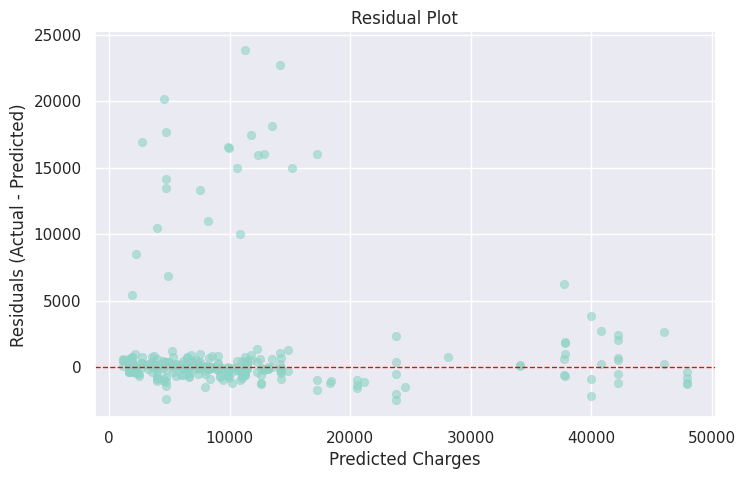

In [74]:
# Calculate residuals # Grid search
residual = y_test - y_pred_random_search

# Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_random_search, y=residual, alpha=0.6, edgecolor=None)

# Add reference lines
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals (Actual - Predicted)")
sns.despine()
plt.show()


### **Actual vs Prediction Scatterplot**

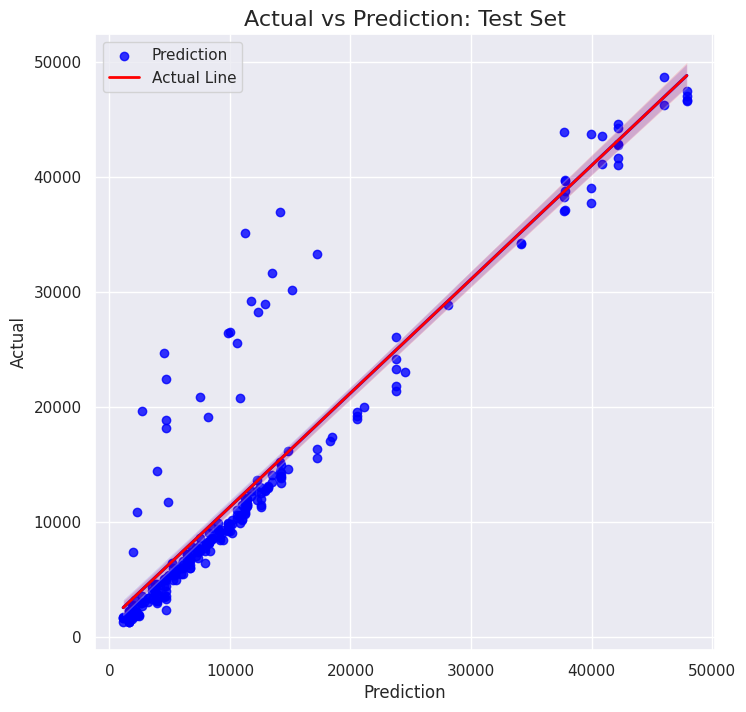

In [76]:
plt.figure(figsize=(8,8))

sns.regplot(y=y_test, x=y_pred_random_search, color='blue', label='Prediction')
sns.regplot(y=y_test, x=y_pred_random_search, line_kws = {'linewidth': 2}, scatter=False, color='red', label='Actual Line')

plt.title('Actual vs Prediction: Test Set', fontsize=16)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.legend()
plt.show()

### **Feature importance**

In [66]:
# Feature importance
df_feature_importances_randomsearch = pd.DataFrame({
    'feature': transformer.get_feature_names_out(),
    'importance': best_model_random_search['algo'].feature_importances_
}).sort_values('importance', ascending=False)

df_feature_importances_randomsearch

,feature,importance
4,onehot__smoker_yes,0.407898
0,scaler__age,0.362353
1,scaler__bmi,0.200263
2,scaler__children,0.025243
3,onehot__sex_male,0.003736
6,onehot__region_southeast,0.000315
7,onehot__region_southwest,0.000193
5,onehot__region_northwest,0.000000


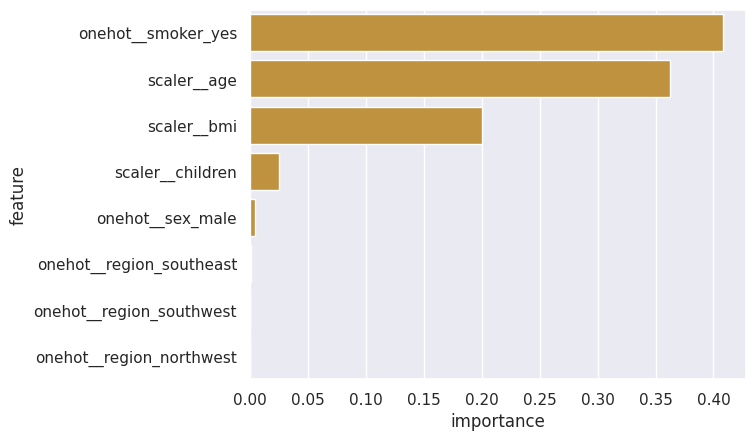

In [67]:
sns.barplot(data=df_feature_importances_randomsearch, x='importance', y='feature', color='orange', saturation=0.5)
plt.show()

**Overall result**

| **Model Version**                | **MAE (Train Set)** | **MAE (Test Set)** |  **Improvement vs Baseline** |
| -------------------------------- | ------------------: | -----------------: | ---------------------------: |
| Before Tuning (Benchmark)        |                1980 |               1910 |                            — |
| After Tuning – Grid Search       |                1771 |               1825 | ↓ ~9% (train) / ↓ ~4% (test) |
| After Tuning – Randomized Search |                1795 |               1811 | ↓ ~9% (train) / ↓ ~5% (test) |





## **Conclusion**

Hyperparameter tuning significantly enhanced the Decision Tree model’s predictive performance. Both Grid Search and Randomized Search successfully reduced the model’s Mean Absolute Error (MAE) on both training and testing sets, demonstrating improved accuracy and better generalization. Although Randomized Search achieved a slightly lower test MAE (1811) than Grid Search (1825), the overall improvement (Reduction of MAE) from the baseline (1910) confirms that the model now fits the data more efficiently without overfitting.